In [28]:
import pandas as pd
import numpy as np
from collections import defaultdict
from operator import itemgetter
from IPython.display import display, IFrame

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.utils import shuffle

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [30]:
# helpful functions

def showAll(status=True):
    if status:
        pd.set_option("display.max_rows", None)
    else:
        pd.set_option("display.max_rows", 10)

def sortListofTuples(tuples, reverse=False):
    return sorted(tuples, key=itemgetter(1), reverse=reverse)

def standardize(data, ddof=0):
    return (data - np.mean(data)) / np.std(data, ddof=ddof)

In [31]:
# Import dataset

df = pd.read_csv('C:/Users/phuro/UCSD/ULI/H2H/ULI-UCSD_H2H/LIHTC_analysis/data/stratified_lihtc.csv', index_col=0)
df.head()

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,is_highMOE,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0,636179.0
47271,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0,333463.0
47296,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,1,562375.0
12677,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0,385630.0
47256,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,0,806735.0


In [32]:
# cast values to type category

for col in df.columns:
    if col not in ['is_highMOE', 'target']:
        df[col] = df[col].astype('category')
    else:
        continue

In [33]:
df.drop(columns=['is_highMOE'], inplace=True)

In [34]:
# GOALs:
# 
# stratify: have 2 models: 1 model with lower allocation amounts, and 1 with larger amounts
# following the histogram of allocamt, cut at 0.8 mil to separate two datasets

# try logistic reg

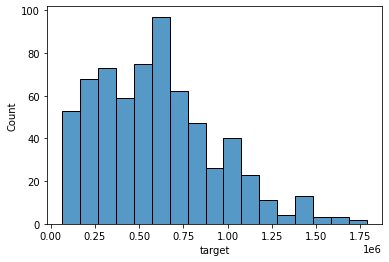

In [35]:
sns.histplot(df.target);

In [36]:
# split projects into low and high allocation amount at 0.8 million

dfLow = df[df.target < 800000]
dfHigh = df[df.target >= 800000]

dfLow['target'] = standardize(dfLow.target)
dfHigh['target'] = standardize(dfHigh.target)

print(dfLow.shape)
print(dfHigh.shape)

(498, 25)
(161, 25)


In [37]:
df.head(1)

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,636179.0


In [38]:
# Model for projects with lower allocation amounts

formulaLow = 'target ~ ' + ' + '.join(dfLow.columns.difference(['target']))
print(formulaLow)
mdlLow = smf.ols(formulaLow, data=dfLow).fit()
print(mdlLow.summary())

target ~ basis + bond + cdbg + credit + dda + fmha_515 + fmha_538 + home + hopevi + inc_ceil + low_ceil + metro + mff_ra + non_prof + qct + rentassist + tcep + trgt_dis + trgt_eld + trgt_fam + trgt_hml + trgt_other + trgt_pop + type
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     4.416
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.00e-12
Time:                        20:53:42   Log-Likelihood:                -646.40
No. Observations:                 498   AIC:                             1353.
Df Residuals:                     468   BIC:                             1479.
Df Model:                          29                                         
Covariance Type:            nonrobust                   

In [39]:
# get signicant variables (pval < 5%)

sigLow = mdlLow.pvalues[mdlLow.pvalues < 0.05].index.to_list()
sigLow

['basis[T.2.0]',
 'bond[T.1.0]',
 'dda[T.2.0]',
 'fmha_515[T.1.0]',
 'mff_ra[T.2.0]',
 'qct[T.2.0]',
 'type[T.2.0]',
 'type[T.3.0]']

In [40]:
for var in sigLow:
    print(f"{var}: {mdlLow.params[var]}")

basis[T.2.0]: -0.26863141928655593
bond[T.1.0]: -0.30894341733735475
dda[T.2.0]: -0.4127498181507251
fmha_515[T.1.0]: -0.7017662523997632
mff_ra[T.2.0]: 0.8920685313751034
qct[T.2.0]: -0.2727904750904759
type[T.2.0]: -0.32084274459946266
type[T.3.0]: -0.693450652128624


In [46]:
# Model for projects with higher allocation amounts

formulaHigh = 'target ~ ' + ' + '.join(dfHigh.columns.difference(['target']))
print(formulaHigh)
mdlHigh = smf.ols(formulaHigh, data=dfHigh).fit()
print(mdlHigh.summary())

target ~ basis + bond + cdbg + credit + dda + fmha_515 + fmha_538 + home + hopevi + inc_ceil + low_ceil + metro + mff_ra + non_prof + qct + rentassist + tcep + trgt_dis + trgt_eld + trgt_fam + trgt_hml + trgt_other + trgt_pop + type
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.485
Date:                Fri, 10 May 2024   Prob (F-statistic):             0.0798
Time:                        20:55:44   Log-Likelihood:                -208.90
No. Observations:                 161   AIC:                             469.8
Df Residuals:                     135   BIC:                             549.9
Df Model:                          25                                         
Covariance Type:            nonrobust                   

In [48]:
# get signicant variables (pval < 5%)

sigHigh = mdlHigh.pvalues[mdlHigh.pvalues < 0.10].index.to_list()
sigHigh

['inc_ceil[T.2.0]']

In [49]:
for var in sigHigh:
    print(f"{var}: {mdlHigh.params[var]}")

inc_ceil[T.2.0]: 0.5391624368787323


##### Try a binary classification problem, predict whether a project will be allocated over 0.8 million, or not

In [50]:
dfLogit = df.copy()
dfLogit['target'] = [1 if _ >= 800000 else 0 for _ in df.target]

In [51]:
dfLogit.head()

,inc_ceil,low_ceil,non_prof,basis,bond,mff_ra,fmha_515,fmha_538,home,cdbg,hopevi,tcep,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,type,credit,metro,dda,qct,target
29023,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0
47271,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0
47296,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,0
12677,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0
47256,2.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1


In [52]:
# Model

formula = 'target ~ ' + ' + '.join(dfLogit.columns.difference(['target']))
print(formula)
mdl = smf.logit(formula, data=dfLogit).fit()
print(mdl.summary())

target ~ basis + bond + cdbg + credit + dda + fmha_515 + fmha_538 + home + hopevi + inc_ceil + low_ceil + metro + mff_ra + non_prof + qct + rentassist + tcep + trgt_dis + trgt_eld + trgt_fam + trgt_hml + trgt_other + trgt_pop + type
         Current function value: 0.451327
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  659
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                           29
Date:                Fri, 10 May 2024   Pseudo R-squ.:                  0.1883
Time:                        20:57:14   Log-Likelihood:                -297.42
converged:                      False   LL-Null:                       -366.40
Covariance Type:            nonrobust   LLR p-value:                 3.939e-16
                        coef    std err          z      P>|z|      [0

In [53]:
# get signicant variables (pval < 5%)

sigLogit = mdl.pvalues[mdl.pvalues < 0.01].index.to_list()
sigLogit

['low_ceil[T.2.0]', 'non_prof[T.2.0]', 'qct[T.2.0]', 'type[T.2.0]']

In [54]:
for var in sigLogit:
    print(f"{var}: {mdl.params[var]}")

low_ceil[T.2.0]: -1.0083672715034204
non_prof[T.2.0]: 0.7365154237055345
qct[T.2.0]: -0.8543916861424938
type[T.2.0]: -0.8800509991858744
